In [1]:
######################## PetFinder Malaysia Modeling ##############################

#author: Zoë Kimpel
#date: 4.25.19

#libraries
import sys
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn import tree
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import bokeh
from keras.callbacks import EarlyStopping, ModelCheckpoint #early stopping
from keras import models
from keras import layers
from keras import regularizers
from keras.callbacks import LambdaCallback
from keras.utils import to_categorical
import time

plt.style.use('bmh')
%matplotlib inline

In [32]:
#import the dataset

pet = pd.read_csv('train_features_w_state_info.csv', sep = ',')

#pet.describe()

## Data Clean-up / Transformations 

In [3]:
#check for missing
#% of columns that are NA
columns = pet.columns
percent_missing = pet.isnull().sum() * 100 / len(pet)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

#name is missing - remove column from final training set

,column_name,percent_missing
Type,Type,0.000000
Sterilized,Sterilized,0.000000
Sterilized_Name,Sterilized_Name,0.000000
Health,Health,0.000000
Health_Name,Health_Name,0.000000
Quantity,Quantity,0.000000
Fee,Fee,0.000000
State,State,0.000000
State_Label,State_Label,0.000000
RescuerID,RescuerID,0.000000


In [33]:
### AH ###

### Drop Variables - Name and 2017GDPpercapita_RM ###
pet.drop('2017GDPpercapita_RM', axis=1, inplace=True)
pet.drop('Name', axis=1, inplace=True)

### Change Fee to Yes or No vs $ amounts ###
pet['Fee'] = pet['Fee'].apply(lambda x: 'No Fee' if x == 0 else 'Fee')

In [5]:
pet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 45 columns):
Type                    14993 non-null int64
Type_Name               14993 non-null object
Age                     14993 non-null int64
Age_Yr                  14993 non-null int64
Breed1                  14993 non-null int64
Breed1_Name             14993 non-null object
Breed2                  14993 non-null int64
Breed2_Name             14993 non-null object
Gender                  14993 non-null int64
Gender_Name             14993 non-null object
Color1                  14993 non-null int64
Color1_Name             14993 non-null object
Color2                  14993 non-null int64
Color2_Name             14993 non-null object
Color3                  14993 non-null int64
Color3_Name             14993 non-null object
MaturitySize            14993 non-null int64
MaturitySize_Name       14993 non-null object
FurLength               14993 non-null int64
FurLength_Name          1499

In [34]:
### Convert Data Types ### 
pet['Type'] = pet['Type'].astype('category')
pet['Breed1'] = pet['Breed1'].astype('category')
pet['Breed2'] = pet['Breed2'].astype('category')
pet['Color1'] = pet['Color1'].astype('category')
pet['Color2'] = pet['Color2'].astype('category')
pet['Color3'] = pet['Color3'].astype('category')
pet['MaturitySize'] = pet['MaturitySize'].astype('category')
pet['FurLength'] = pet['FurLength'].astype('category')
pet['Vaccinated'] = pet['Vaccinated'].astype('category')
pet['Dewormed'] = pet['Dewormed'].astype('category')
pet['Sterilized'] = pet['Sterilized'].astype('category')
pet['Health'] = pet['Health'].astype('category')
pet['Quantity'] = pet['Quantity'].astype('category')
pet['State'] = pet['State'].astype('category') 
pet['Gender'] = pet['Gender'].astype('category')  

fee_map = {'Fee': {'No Fee': 0, 'Fee': 1}}
pet.replace(fee_map, inplace=True)
pet['Fee'] = pet['Fee'].astype('category') 

stateterr_map = {'StateorTerritory': {'State': 1, 'Territory': 2}}
pet.replace(stateterr_map, inplace=True)
pet['StateorTerritory'] = pet['StateorTerritory'].astype('category') 

region_map = {'Region': {'East_Malaysia': 1, 'West_Malaysia': 2}}
pet.replace(region_map, inplace=True)
pet['Region'] = pet['Region'].astype('category') 

In [35]:
### Scale Numerical Data ###
scaler = StandardScaler()
pet['VideoAmt'] = scaler.fit_transform(pet['VideoAmt'].values.reshape(-1,1))
pet['PhotoAmt'] = scaler.fit_transform(pet['PhotoAmt'].values.reshape(-1,1))
pet['Population'] = scaler.fit_transform(pet['Population'].values.reshape(-1,1))
pet['Population_Density'] = scaler.fit_transform(pet['Population_Density'].values.reshape(-1,1))
pet['Age'] = scaler.fit_transform(pet['Age'].values.reshape(-1,1))
pet['TotalArea(km2)'] = scaler.fit_transform(pet['TotalArea(km2)'].values.reshape(-1,1))
pet['2017GDPpercapita_USD'] = scaler.fit_transform(pet['2017GDPpercapita_USD'].values.reshape(-1,1))
pet['HDI'] = scaler.fit_transform(pet['HDI'].values.reshape(-1,1))
pet['TotalArea(km2)'] = scaler.fit_transform(pet['TotalArea(km2)'].values.reshape(-1,1))


C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was

## Create Modeling DF and Train/Test Sets 

In [36]:
###################### Modeling ######################

#dataprep

#split into X & Y #Not including RescuerID or PetID (too many categories)
X_features = ['Type', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 
              'Breed1', 'Breed2','Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength',
             'Quantity', 'State', 'StateorTerritory', 'Region']
X = pet[X_features]
X.replace(' ', '')
Y = pet['AdoptionSpeed']
Y = Y.astype('category') #Changed from int to category

#split data into test and train
validation_size = .2
random_seed = 1234

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = random_seed)


In [9]:
X.dtypes

Type                    category
Sterilized              category
Health                  category
Fee                     category
VideoAmt                 float64
PhotoAmt                 float64
Population               float64
TotalArea(km2)           float64
HDI                      float64
Population_Density       float64
Dewormed                category
2017GDPpercapita_USD     float64
Vaccinated              category
Age                      float64
Breed1                  category
Breed2                  category
Gender                  category
Color1                  category
Color2                  category
Color3                  category
MaturitySize            category
FurLength               category
Quantity                category
State                   category
StateorTerritory        category
Region                  category
dtype: object

## Combined Cats and Dogs Models 

### Logistic Regression, DecisionTreeClassifier, GaussianNB 

In [11]:
# 3 basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = random_seed) #10 fold cross validation
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = ("Model:", name, cv_results.mean())
    print(msg)

C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Allison\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: 

('Model:', 'LR', 0.28897595218237426)
('Model:', 'CART', 0.3313322212955241)
('Model:', 'NB', 0.30582582707812067)


In [12]:
# looking at Decision Tree Classifier
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
predictions_DT = DT.predict(x_test)
print("done")


#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test, predictions_DT))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, predictions_DT))
print("Classification Report", "\n", classification_report(y_test, predictions_DT))

done
Accuracy Score 
 0.32277425808602866
Confusion Matrix 
 [[  7  23  14  16  21]
 [ 14 158 175 126 119]
 [ 29 176 259 170 172]
 [ 14 129 167 184 149]
 [ 20 130 181 186 360]]
Classification Report 
               precision    recall  f1-score   support

           0       0.08      0.09      0.08        81
           1       0.26      0.27      0.26       592
           2       0.33      0.32      0.32       806
           3       0.27      0.29      0.28       643
           4       0.44      0.41      0.42       877

   micro avg       0.32      0.32      0.32      2999
   macro avg       0.27      0.27      0.27      2999
weighted avg       0.33      0.32      0.32      2999



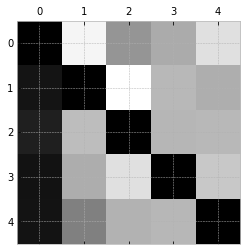

In [13]:
### Confusion Matrix Graph ###
conf_mx = confusion_matrix(y_test, predictions_DT)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Above graph compares errors the classifer makes. Rows represent actual classes and columns represent predicted classes. the brighter the block, the more likely the image gets misclassified.

0's are most often misclassified as 4
1's are most often misclassified as 2
3's are most often misclassified as 2

The vertical black line at 0 indicates that the model is really good at NOT classifying points as 0s when they aren't actually 0s.

### Random Forest 

In [14]:
#train the algorithm

RF = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'sqrt', #Changed to sqrt since classification problem
                                    bootstrap = False,
                                    random_state = random_seed)
RF.fit(x_train, y_train)
y_pred_RF = RF.predict(x_test)

#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test, y_pred_RF))
print("Confusion Matrix", "\n",  confusion_matrix(y_test, y_pred_RF))
print("Classification Report", "\n", classification_report(y_test, y_pred_RF))

Accuracy Score 
 0.41547182394131377
Confusion Matrix 
 [[  8  25  20  11  17]
 [  5 205 177  81 124]
 [  8 181 312 130 175]
 [  3  99 180 201 160]
 [  1  94 158 104 520]]
Classification Report 
               precision    recall  f1-score   support

           0       0.32      0.10      0.15        81
           1       0.34      0.35      0.34       592
           2       0.37      0.39      0.38       806
           3       0.38      0.31      0.34       643
           4       0.52      0.59      0.56       877

   micro avg       0.42      0.42      0.42      2999
   macro avg       0.39      0.35      0.35      2999
weighted avg       0.41      0.42      0.41      2999



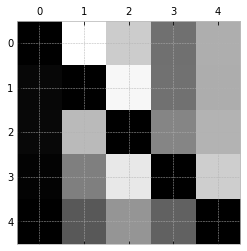

In [15]:
### Confusion Matrix Graph ###
conf_mx = confusion_matrix(y_test, y_pred_RF)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Above graph compares errors the classifer makes. Rows represent actual classes and columns represent predicted classes. the brighter the block, the more likely the image gets misclassified.

0's are most often misclassified as 1
1's are most often misclassified as 2
3's are most often misclassified as 2

The vertical black line at 0 indicates that the model is really good at NOT classifying points as 0s when they aren't actually 0s.

In [16]:
#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), X_features), reverse=True))

Features sorted by their score:

[(0.1386, 'PhotoAmt'), (0.1292, 'Age'), (0.0853, 'Color2'), (0.0841, 'Color1'), (0.0764, 'Breed1'), (0.0546, 'Breed2'), (0.0455, 'Gender'), (0.0428, 'FurLength'), (0.0422, 'Quantity'), (0.0418, 'Color3'), (0.0403, 'MaturitySize'), (0.0362, 'Dewormed'), (0.0313, 'Vaccinated'), (0.0288, 'Sterilized'), (0.0258, 'Fee'), (0.0127, 'VideoAmt'), (0.0114, 'Population'), (0.0106, 'Health'), (0.0105, 'HDI'), (0.0103, 'State'), (0.0102, 'TotalArea(km2)'), (0.0097, 'Population_Density'), (0.0092, 'Type'), (0.0091, '2017GDPpercapita_USD'), (0.0033, 'StateorTerritory'), (0.0002, 'Region')]


Feature Importance Ranking
1. PhotoAmt (0.138625)
2. Age (0.129193)
3. Color2 (0.085317)
4. Color1 (0.084134)
5. Breed1 (0.076382)
6. Breed2 (0.054621)
7. Gender (0.045535)
8. FurLength (0.042765)
9. Quantity (0.042153)
10. Color3 (0.041797)
11. MaturitySize (0.040305)
12. Dewormed (0.036193)
13. Vaccinated (0.031254)
14. Sterilized (0.028800)
15. Fee (0.025761)
16. VideoAmt (0.012654)
17. Population (0.011403)
18. Health (0.010595)
19. HDI (0.010458)
20. State (0.010304)
21. TotalArea(km2) (0.010198)
22. Population_Density (0.009720)
23. Type (0.009187)
24. 2017GDPpercapita_USD (0.009088)
25. StateorTerritory (0.003326)
26. Region (0.000235)


<function matplotlib.pyplot.show(*args, **kw)>

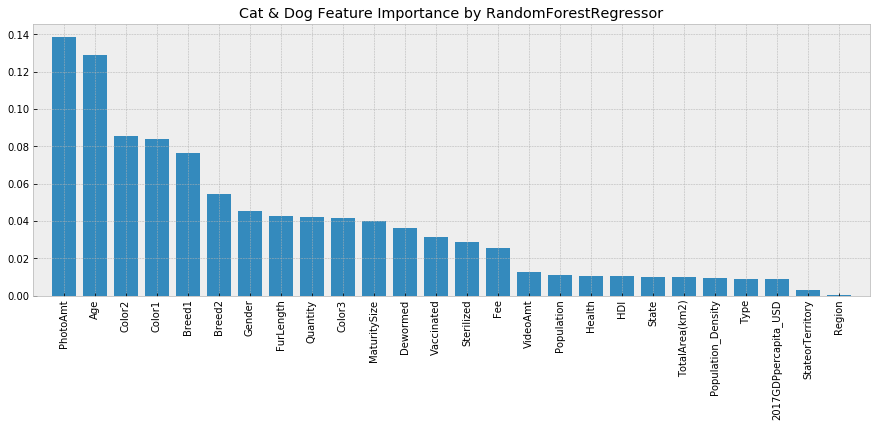

In [17]:
### Feature Importance Graph ###
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
names = []
indices = np.argsort(importances)[:-27:-1]

print("Feature Importance Ranking")
for i in range(26):
    print("%d. %s (%f)" % (i+1, X_features[indices[i]], importances[indices[i]]))
    names.append(X_features[indices[i]])

plt.figure(figsize=(15,5))
plt.title('Cat & Dog Feature Importance by RandomForestRegressor')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), names, rotation='vertical', fontsize=10)
plt.xlim([-1,26])
plt.show

### Dense Neural Network 

In [42]:
## Set parameters ##
#get number of columns in training data
n_cols = x_train.shape[1]
hidden_nodes = 2
output_nodes = 5  # 5 possible classes for digits 0-4
epcnum = 100 # number of epochs
bsize = 200 # number of mini batches
l2_wgt_reg = 0.001 #every coefficient in weight matrix of layer will add # * weight coefficint to total loss of network,
## penalizes model and essentially makes it more resistant to overfitting (Chollet, pg 108)

### Network Architecture ##
network = models.Sequential()
network.add(layers.Dense(hidden_nodes, activation='relu', kernel_regularizer=regularizers.l2(l2_wgt_reg),
                         input_shape=(n_cols,))) 
network.add(layers.Dropout(0.5))
network.add(layers.Dense(output_nodes, activation='softmax')) #Output layer, 5 possible classes for digits 0-4

## Compilation Step ##
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Set callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
ModChk =  ModelCheckpoint(filepath='best_model', monitor='val_loss', save_best_only=True)
wgts = []
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: wgts.append(network.layers[0].get_weights()))

In [38]:
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Train on 9595 samples, validate on 2399 samples
Epoch 1/100
9595/9595 [==============================] - 1s 78us/step - loss: 7.1596 - acc: 0.2378 - val_loss: 12.2642 - val_acc: 0.2393
Epoch 2/100
9595/9595 [==============================] - 0s 35us/step - loss: 4.1196 - acc: 0.2608 - val_loss: 1.5818 - val_acc: 0.2743
Epoch 3/100
9595/9595 [==============================] - 0s 27us/step - loss: 1.5744 - acc: 0.2774 - val_loss: 1.5698 - val_acc: 0.2743
Epoch 4/100
9595/9595 [==============================] - 0s 27us/step - loss: 1.5624 - acc: 0.2774 - val_loss: 1.5588 - val_acc: 0.2743
Epoch 5/100
9595/9595 [==============================] - 0s 29us/step - loss: 1.5513 - acc: 0.2774 - val_loss: 1.5488 - val_acc: 0.2743
Epoch 6/100
9595/9595 [==============================] - 0s 27us/step - loss: 1.5415 - acc: 0.2734 - val_loss: 1.5401 - val_acc: 0.2743
Epoch 7/100
9595/9595 [==============================] - 0s 32us/step - loss: 1.5328 - acc: 0.2774 - val_loss: 1.5323 - val_acc: 0.2743

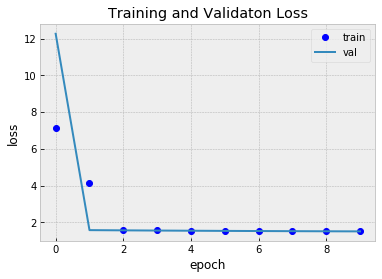

2999/2999 [==============================] - 0s 46us/step
test_acc: 0.29243081031977713


In [43]:
## Train/Fit Model to Training Data & Evaluate on Validation Data
t0 = time.time()
history = network.fit(x_train, y_train, epochs=epcnum, batch_size=bsize, validation_split=0.2, callbacks=[earlystop,
                    ModChk,print_weights])
t1 =time.time()
print("Training took {:.2f}s".format(t1-t0))
print("Early Stopping at Epoch #: ", earlystop.stopped_epoch-1)


## Plot loss
plt.plot(history.history['loss'][:earlystop.stopped_epoch-1], "bo")
plt.plot(history.history['val_loss'][:earlystop.stopped_epoch-1])
plt.title('Training and Validaton Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Model Performance on Test Data
t0=time.time()
test_loss, test_acc = network.evaluate(x_test, y_test)
t1 =time.time()
print('test_acc:', test_acc)
#print("Predicting on Model ", modnum, " {:.2f}s".format(t1-t0))

## Cat vs Dog Specific Models 

In [68]:
#separate into cat vs. dog specific models
dog = pet[pet['Type_Name'] == 'Dog']
cat = pet[pet['Type_Name'] == 'Cat']

### Dog Specific Models 

Accuracy Score 
 0.42778119237861095
Confusion Matrix 
 [[  2   9  15   7   7]
 [  4 103  74  38  54]
 [  6  79 158  92 113]
 [  6  50  93 133 106]
 [  2  33  72  71 300]]
Classification Report 
               precision    recall  f1-score   support

           0       0.10      0.05      0.07        40
           1       0.38      0.38      0.38       273
           2       0.38      0.35      0.37       448
           3       0.39      0.34      0.36       388
           4       0.52      0.63      0.57       478

   micro avg       0.43      0.43      0.43      1627
   macro avg       0.35      0.35      0.35      1627
weighted avg       0.42      0.43      0.42      1627



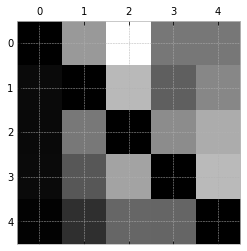

Features sorted by their score:

[(0.146, 'PhotoAmt'), (0.1379, 'Age'), (0.0839, 'Color2'), (0.0804, 'Color1'), (0.0635, 'Breed1'), (0.0544, 'Breed2'), (0.0463, 'FurLength'), (0.0432, 'Gender'), (0.0417, 'MaturitySize'), (0.0396, 'Color3'), (0.0385, 'Quantity'), (0.0379, 'Dewormed'), (0.0374, 'Vaccinated'), (0.0343, 'Sterilized'), (0.0255, 'Fee'), (0.0129, 'Population'), (0.0123, 'VideoAmt'), (0.0111, 'TotalArea(km2)'), (0.0101, 'State'), (0.01, 'Health'), (0.01, 'HDI'), (0.01, '2017GDPpercapita_USD'), (0.0097, 'Population_Density'), (0.0031, 'StateorTerritory'), (0.0001, 'Region'), (0.0, 'Type')]
Feature Importance Ranking
1. PhotoAmt (0.146017)
2. Age (0.137891)
3. Color2 (0.083893)
4. Color1 (0.080366)
5. Breed1 (0.063529)
6. Breed2 (0.054409)
7. FurLength (0.046280)
8. Gender (0.043236)
9. MaturitySize (0.041665)
10. Color3 (0.039618)
11. Quantity (0.038504)
12. Dewormed (0.037901)
13. Vaccinated (0.037355)
14. Sterilized (0.034285)
15. Fee (0.025530)
16. Population (0.012940)
17. 

<function matplotlib.pyplot.show(*args, **kw)>

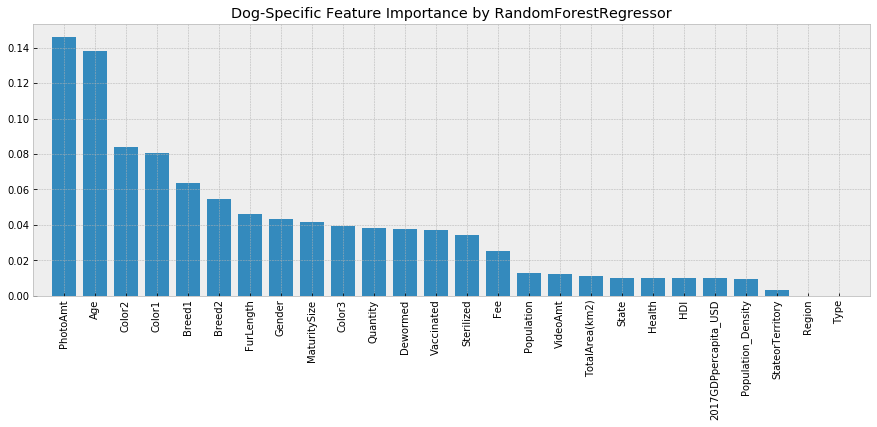

In [70]:
########## dog

###################### Modeling ######################

#dataprep

#split into X & Y
X_features = ['Type', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 
              'Breed1', 'Breed2','Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength',
             'Quantity', 'State', 'StateorTerritory', 'Region']
X_dog = dog[X_features]
X_dog.replace(' ', '')
Y_dog = dog['AdoptionSpeed']
Y_dog = Y_dog.astype('category') #Changed from int to category

#split data into test and train
validation_size = .2
random_seed = 1234

x_train_dog, x_test_dog, y_train_dog, y_test_dog = model_selection.train_test_split(X_dog, Y_dog, test_size = validation_size, random_state = random_seed)


#train the algorithm

RF_dog = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'sqrt', #changed to sqrt
                                    bootstrap = False,
                                    random_state = random_seed)
RF_dog.fit(x_train_dog, y_train_dog)
y_pred_RF_dog = RF_dog.predict(x_test_dog)

#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test_dog, y_pred_RF_dog))
print("Confusion Matrix", "\n",  confusion_matrix(y_test_dog, y_pred_RF_dog))
print("Classification Report", "\n", classification_report(y_test_dog, y_pred_RF_dog))

### Confusion Matrix Graph ###
conf_mx = confusion_matrix(y_test_dog, y_pred_RF_dog)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF_dog.feature_importances_), X_features), reverse=True))

### Feature Importance Graph ###
importances = RF_dog.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_dog.estimators_], axis=0)
names = []
indices = np.argsort(importances)[:-27:-1]

print("Feature Importance Ranking")
for i in range(26):
    print("%d. %s (%f)" % (i+1, X_features[indices[i]], importances[indices[i]]))
    names.append(X_features[indices[i]])

plt.figure(figsize=(15,5))
plt.title('Dog-Specific Feature Importance by RandomForestRegressor')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), names, rotation='vertical', fontsize=10)
plt.xlim([-1,26])
plt.show


### Cat-Specific Models 

Accuracy Score 
 0.37973760932944606
Confusion Matrix 
 [[  2  10   9   7  12]
 [  4 118 108  45  60]
 [  4  91 144  58  68]
 [  3  56  72  55  72]
 [  2  56  70  44 202]]
Classification Report 
               precision    recall  f1-score   support

           0       0.13      0.05      0.07        40
           1       0.36      0.35      0.35       335
           2       0.36      0.39      0.38       365
           3       0.26      0.21      0.24       258
           4       0.49      0.54      0.51       374

   micro avg       0.38      0.38      0.38      1372
   macro avg       0.32      0.31      0.31      1372
weighted avg       0.37      0.38      0.37      1372



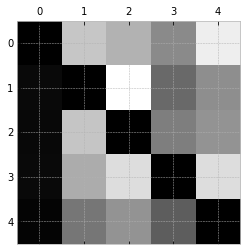

Features sorted by their score:

[(0.1409, 'PhotoAmt'), (0.1226, 'Age'), (0.0871, 'Color2'), (0.0827, 'Color1'), (0.081, 'Breed1'), (0.0542, 'Breed2'), (0.052, 'Gender'), (0.0461, 'Color3'), (0.0456, 'MaturitySize'), (0.0436, 'Quantity'), (0.0426, 'FurLength'), (0.03, 'Dewormed'), (0.0281, 'Sterilized'), (0.0263, 'Fee'), (0.0261, 'Vaccinated'), (0.0121, 'VideoAmt'), (0.0115, 'Population'), (0.011, 'Health'), (0.0108, 'HDI'), (0.0105, 'TotalArea(km2)'), (0.0104, 'State'), (0.0103, '2017GDPpercapita_USD'), (0.0102, 'Population_Density'), (0.0039, 'StateorTerritory'), (0.0004, 'Region'), (0.0, 'Type')]
Feature Importance Ranking
1. PhotoAmt (0.140944)
2. Age (0.122565)
3. Color2 (0.087085)
4. Color1 (0.082699)
5. Breed1 (0.080969)
6. Breed2 (0.054228)
7. Gender (0.052041)
8. Color3 (0.046084)
9. MaturitySize (0.045609)
10. Quantity (0.043605)
11. FurLength (0.042592)
12. Dewormed (0.029970)
13. Sterilized (0.028104)
14. Fee (0.026284)
15. Vaccinated (0.026057)
16. VideoAmt (0.012141)
17. 

<function matplotlib.pyplot.show(*args, **kw)>

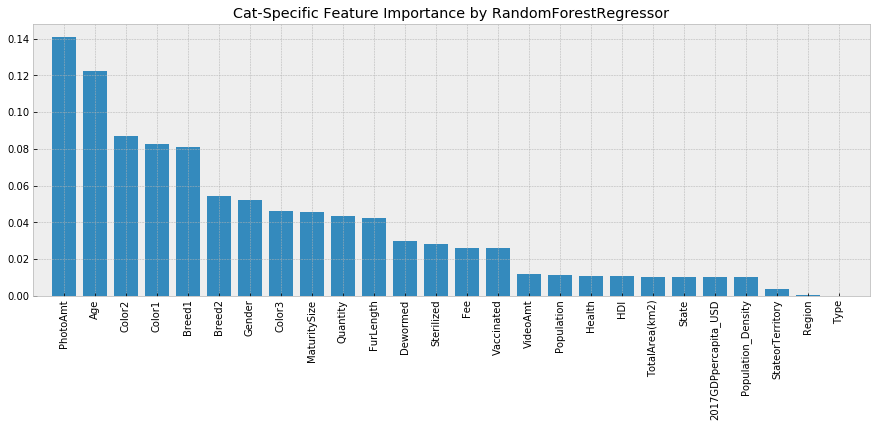

In [74]:
########## cat

###################### Modeling ######################

#dataprep

#split into X & Y
X_features = ['Type', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt','Population',
             'TotalArea(km2)','HDI', 'Population_Density', 'Dewormed', '2017GDPpercapita_USD', 'Vaccinated', 'Age', 
              'Breed1', 'Breed2','Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength',
             'Quantity', 'State', 'StateorTerritory', 'Region']
X_cat = cat[X_features]
X_cat.replace(' ', '')
Y_cat = cat['AdoptionSpeed']
Y_cat = Y_cat.astype('int')

#split data into test and train
validation_size = .2
random_seed = 1234

x_train_cat, x_test_cat, y_train_cat, y_test_cat = model_selection.train_test_split(X_cat, Y_cat, test_size = validation_size, random_state = random_seed)


#train the algorithm

RF_cat = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'sqrt',
                                    bootstrap = False,
                                    random_state = random_seed)
RF_cat.fit(x_train_cat, y_train_cat)
y_pred_RF_cat = RF_cat.predict(x_test_cat)

#how accuracy is it?
print("Accuracy Score \n", accuracy_score(y_test_cat, y_pred_RF_cat))
print("Confusion Matrix", "\n",  confusion_matrix(y_test_cat, y_pred_RF_cat))
print("Classification Report", "\n", classification_report(y_test_cat, y_pred_RF_cat))

### Confusion Matrix Graph ###
conf_mx = confusion_matrix(y_test_cat, y_pred_RF_cat)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


#print the feature importances
print("Features sorted by their score:\n")
print(sorted(zip(map(lambda x: round(x, 4), RF_cat.feature_importances_), X_features), reverse=True))


### Feature Importance Graph ###
importances = RF_cat.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_cat.estimators_], axis=0)
names = []
indices = np.argsort(importances)[:-27:-1]

print("Feature Importance Ranking")
for i in range(26):
    print("%d. %s (%f)" % (i+1, X_features[indices[i]], importances[indices[i]]))
    names.append(X_features[indices[i]])

plt.figure(figsize=(15,5))
plt.title('Cat-Specific Feature Importance by RandomForestRegressor')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), names, rotation='vertical', fontsize=10)
plt.xlim([-1,26])
plt.show


## Correlation Plot 

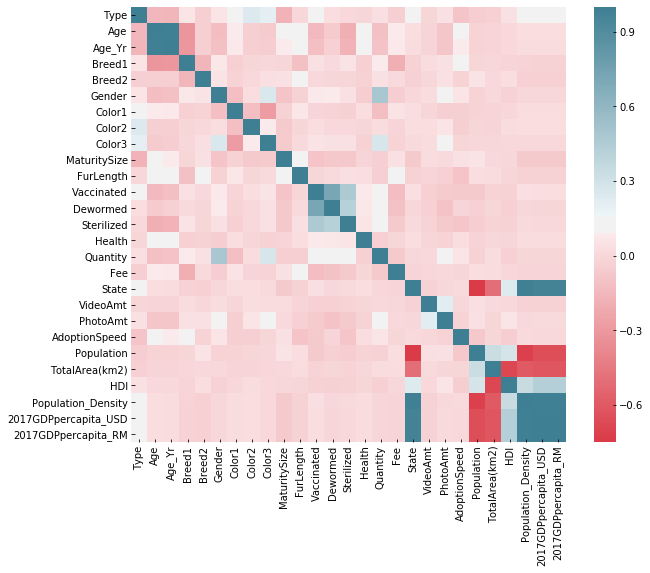

In [34]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = pet.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True),
            square=True, ax=ax)